In [1]:
import pandas as pd
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

import os
from PIL import Image
from torch.utils.data import Dataset
# Import tensorboard
%load_ext tensorboard

<Figure size 640x480 with 0 Axes>

In [2]:
df = pd.read_csv('/Users/bhianca/GRB_envyroment/NIR_GRB.csv')

In [3]:
nir_directory = ['/Users/bhianca/GRB_envyroment/UHS/','/Users/bhianca/GRB_envyroment/VHS/']

In [4]:

class GRBContrastiveDataset(Dataset):

    def __init__(self, df, nir_directory, transform=None):

        self.transform = transform

        self.base_dirs = {
            "UHS": nir_directory[0],
            "VHS": nir_directory[1],
        }

        # GRBs válidos según dataframe
        self.valid_vhs = set(
            df[df["VHS_downloaded"]]["GRB"].astype(str).str.strip()
        )

        self.valid_uhs = set(
            df[df["UHS_downloaded"]]["GRB"].astype(str).str.strip()
        )

        self.samples = []

        print("Indexando imágenes...")

        for survey, folder in self.base_dirs.items():

            if not os.path.isdir(folder):
                continue

            for fname in os.listdir(folder):

                if not fname.lower().endswith(".png"):
                    continue

                # extraer GRB del nombre: GRB_band_N.png
                grb = fname.split("_")[0]

                # filtrar usando dataframe
                if survey == "VHS" and grb not in self.valid_vhs:
                    continue

                if survey == "UHS" and grb not in self.valid_uhs:
                    continue

                full_path = os.path.join(folder, fname)

                self.samples.append((full_path, grb, survey))

        print(f"Total imágenes indexadas: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        img_path, grb, survey = self.samples[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, grb, survey

In [5]:
import torchvision.transforms as transforms

class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for _ in range(self.n_views)]

In [6]:
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
contrast_transforms = transforms.Compose([

    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    # rotaciones 90° sin padding
    transforms.RandomChoice([
        transforms.Lambda(lambda x: x),
        transforms.Lambda(lambda x: TF.rotate(x, 90)),
        transforms.Lambda(lambda x: TF.rotate(x, 180)),
        transforms.Lambda(lambda x: TF.rotate(x, 270)),
    ]),

    # Center crop variable
    transforms.RandomChoice([
        transforms.CenterCrop(100),
        transforms.CenterCrop(128),
        transforms.CenterCrop(160),
        transforms.CenterCrop(192),
        transforms.CenterCrop(224),
    ]),

    # tamaño final fijo para ViT
    transforms.Resize((224, 224)),

    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5,
            hue=0.1
        )
    ], p=0.8),

    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),

    transforms.ToTensor(),

    transforms.Normalize(
        (0.5,0.5,0.5),
        (0.5,0.5,0.5)
    )
])

In [7]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

def split_df_by_grb(df, val_frac=0.2, seed=42):
    df = df.copy()
    df["GRB"] = df["GRB"].astype(str).str.strip()

    # solo GRBs que tengan al menos una carpeta descargada
    mask = df["VHS_downloaded"] | df["UHS_downloaded"]
    df_valid = df[mask]

    grbs = df_valid["GRB"].unique()
    rng = np.random.default_rng(seed)
    rng.shuffle(grbs)

    n_val = int(len(grbs) * val_frac)
    val_grbs = set(grbs[:n_val])
    train_grbs = set(grbs[n_val:])

    df_train = df_valid[df_valid["GRB"].isin(train_grbs)].reset_index(drop=True)
    df_val   = df_valid[df_valid["GRB"].isin(val_grbs)].reset_index(drop=True)

    return df_train, df_val

df_train, df_val = split_df_by_grb(df, val_frac=0.2, seed=42)

train_dataset = GRBContrastiveDataset(
    df_train,
    nir_directory,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2)
)

# para validation, normalmente se usan augmentations más “deterministas”
val_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

val_dataset = GRBContrastiveDataset(
    df_val,
    nir_directory,
    transform=ContrastiveTransformations(val_transforms, n_views=2)  # o n_views=1
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False,
    persistent_workers=True
)

print("Train GRBs:", df_train["GRB"].nunique(), " Train imgs:", len(train_dataset))
print("Val GRBs:", df_val["GRB"].nunique(), " Val imgs:", len(val_dataset))

Indexando imágenes...
Total imágenes indexadas: 3419
Indexando imágenes...
Total imágenes indexadas: 809
Train GRBs: 557  Train imgs: 3419
Val GRBs: 139  Val imgs: 809


/var/folders/b0/_shrs6sx2x5gt6jg55ztqpdr0000gn/T/ipykernel_2568/1123796580.py:15: UserWarning: you are shuffling a 'StringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  rng.shuffle(grbs)


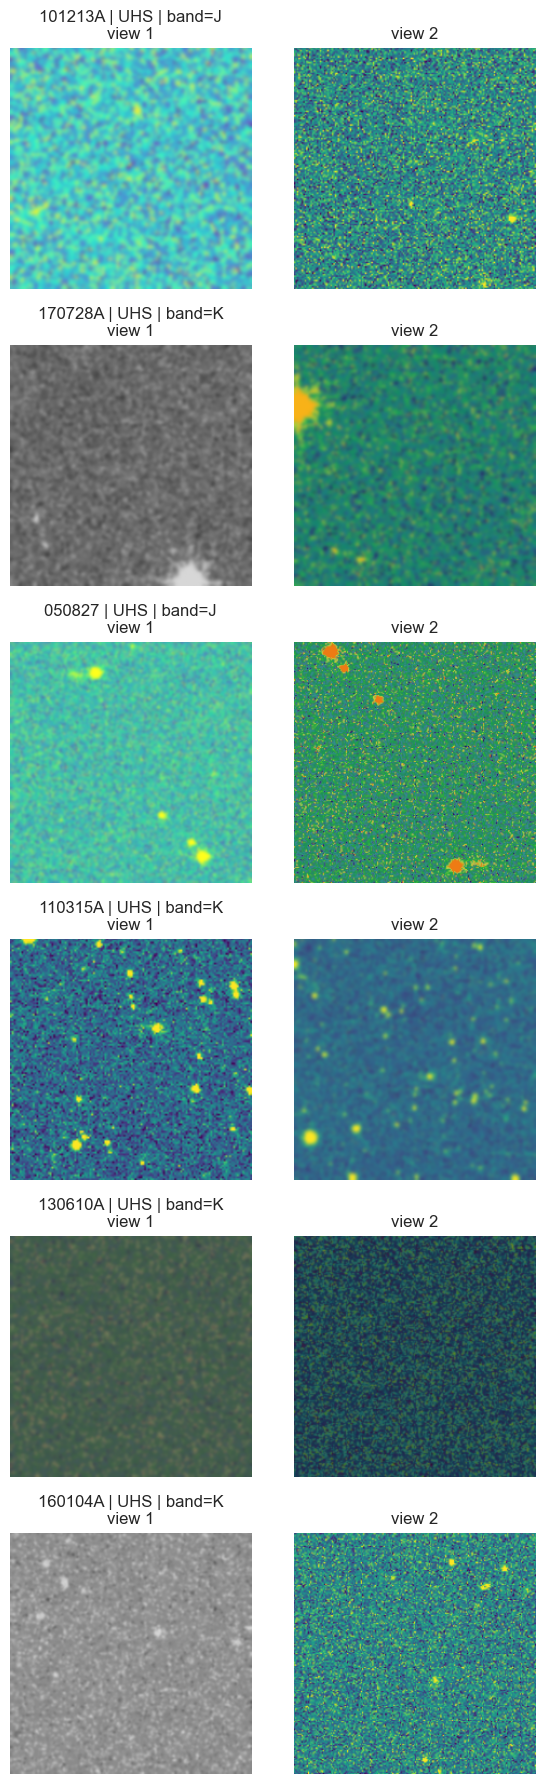

In [8]:
import matplotlib.pyplot as plt
import os

NUM_IMAGES = 6

fig, axes = plt.subplots(NUM_IMAGES, 2, figsize=(6, 3*NUM_IMAGES))

for i in range(NUM_IMAGES):

    views, grb, survey = train_dataset[i]

    # nombre del archivo (para extraer banda)
    img_path, _, _ = train_dataset.samples[i]
    fname = os.path.basename(img_path)

    # GRB_band_N.png
    parts = fname.replace(".png", "").split("_")
    band = parts[1]  # J, H, K, Ks

    for j in range(2):

        img = views[j].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # desnormalizar (asumiendo Normalize 0.5/0.5)

        axes[i, j].imshow(img)
        axes[i, j].axis("off")

        if j == 0:
            axes[i, j].set_title(f"{grb} | {survey} | band={band}\nview 1")
        else:
            axes[i, j].set_title("view 2")

plt.tight_layout()
plt.show()

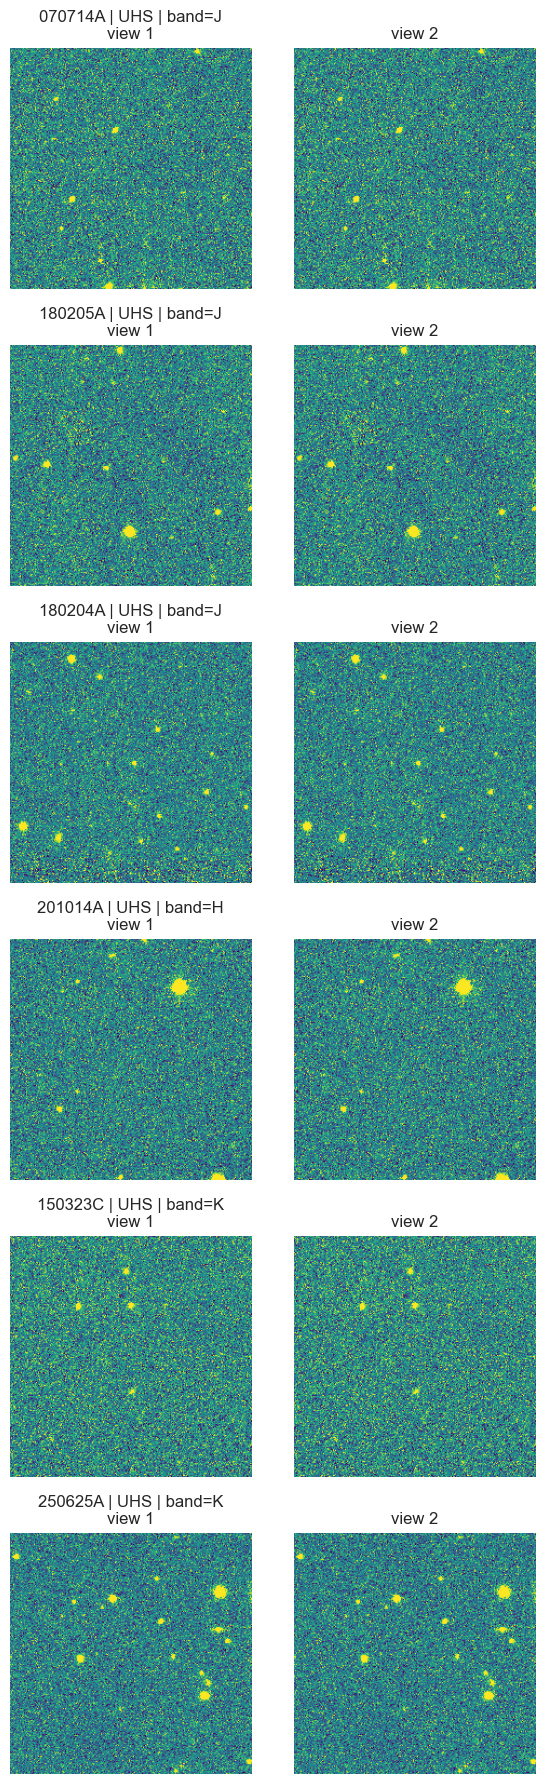

In [9]:
import matplotlib.pyplot as plt
import os

NUM_IMAGES = 6

fig, axes = plt.subplots(NUM_IMAGES, 2, figsize=(6, 3*NUM_IMAGES))

for i in range(NUM_IMAGES):

    views, grb, survey = val_dataset[i]

    # nombre del archivo (para extraer banda)
    img_path, _, _ = val_dataset.samples[i]
    fname = os.path.basename(img_path)

    # GRB_band_N.png
    parts = fname.replace(".png", "").split("_")
    band = parts[1]  # J, H, K, Ks

    for j in range(2):

        img = views[j].permute(1, 2, 0).numpy()
        img = (img * 0.5 + 0.5).clip(0, 1)  # desnormalizar (asumiendo Normalize 0.5/0.5)

        axes[i, j].imshow(img)
        axes[i, j].axis("off")

        if j == 0:
            axes[i, j].set_title(f"{grb} | {survey} | band={band}\nview 1")
        else:
            axes[i, j].set_title("view 2")

plt.tight_layout()
plt.show()

In [14]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _, _ = batch 
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')


def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         log_every_n_steps=5,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,          # importante para contrastive
            pin_memory=True,
            num_workers=0
        )
        
        val_loader = data.DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=0  )
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [15]:
import torch.utils.data as data



In [16]:
CHECKPOINT_PATH = "."
NUM_WORKERS=2
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cpu
Number of workers: 2


In [17]:
simclr_model = train_simclr(batch_size=128,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
Seed set to 42


┏━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ convnet │ ResNet │ 11.5 M │ train │     0 │
└───┴─────────┴────────┴────────┴───────┴───────┘

Trainable params: 11.5 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.5 M                                                                                               
Total estimated model params size (MB): 46                                                                         
Modules in train mode: 71                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

In [21]:
ls

README.md
Resize_image.ipynb
Self-Supervised Contrastive Learning with SimCLR.ipynb
VariationalAutoEncoder.ipynb
example_pytorch_Transferlearning_CNN_vs_Transformer.ipynb
multi_input_NN.ipynb
resize_data_example/
